# DESI DR8 FIBERASSIGN ANALYSIS

* Reads the data generated by JFR.

In [2]:
import sys
import os
import shutil
import glob
import numpy as np
import warnings
import subprocess
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

# Helpful function to deal with multiple warnings
def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))

# Print some debug info
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

Mon Mar 25 00:09:12 PDT 2019
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.29.0.dev2996      
desimodel       0.9.10.dev477       
fiberassign     0.11.1.dev2271

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan

Useful numbers:
Tile radius: 1.627 deg
Tile area:   8.321 sq.deg.


In [3]:
import fitsio
from apcsv import fiberqa
reload(fiberqa)

BLUE FAINT not defined in current targetmask
RED FAINT not defined in current targetmask
BLUE FAINT & WD not defined in current targetmask
RED FAINT & WD not defined in current targetmask


<module 'apcsv.fiberqa' from '/global/u1/a/apcooper/projects/mws_svplan/py/apcsv/fiberqa.py'>

Read JFR's data

In [4]:
bright_tiles_path = '/global/cscratch1/sd/forero/dr8b/input_tiles_bright.fits'

In [5]:
bright_tiles = Table.read(bright_tiles_path)

In [6]:
bright_tiles[0:1]

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
28814,340.41,19.99,5,1,0.0472196,1.05143,3310.55,1.41905,BRIGHT,4


In [7]:
import desiutil

In [8]:
import desimodel.footprint as footprint

In [9]:
all_tiles = footprint.load_tiles()

In [11]:
TILEDIR = "/global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8/"

In [12]:
!ls -l $TILEDIR/tile* |head

-rw-r--r--+ 1 forero desi 4936320 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-028908.fits
-rw-r--r--+ 1 forero desi 3055680 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-028929.fits
-rw-r--r--+ 1 forero desi 5670720 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-028951.fits
-rw-r--r--+ 1 forero desi 3666240 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-029071.fits
-rw-r--r--+ 1 forero desi 5253120 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-029072.fits
-rw-r--r--+ 1 forero desi 5204160 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-029073.fits
-rw-r--r--+ 1 forero desi 5630400 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-029074.fits
-rw-r--r--+ 1 forero desi 3669120 Mar 21 12:46 /global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8//tile-029075.fits
-rw-r--r--+ 1 forero des

In [13]:
# How many tile files?
!ls -l $TILEDIR/tile*.fits |wc -l

298


In [14]:
# How much data?
!du -sh $TILEDIR

1.2G	/global/cscratch1/sd/forero/dr8b/bright_fiber_output_dr8/


In [15]:
%time hdr = fiberqa.load_fiber_headers(TILEDIR)

Have 298 tiles
CPU times: user 1.39 s, sys: 1.31 s, total: 2.7 s
Wall time: 19.5 s


In [16]:
hdr[list(hdr.keys())[0]]


SIMPLE  =                    T / file does conform to FITS standard
BITPIX  =                   16 / number of bits per data pixel
NAXIS   =                    0 / number of data axes
EXTEND  =                    T / FITS dataset may contain extensions
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
EXTNAME = 'PRIMARY '
TILEID  =                41931
TILERA  =                27.65
TILEDEC =                 2.86
REQRA   =                27.65
REQDEC  =                 2.86
FIELDNUM=                    0
FBAVER  = '1.0.0.dev2366'

In [17]:
# FTARGETS extension is direct from fiberassign -- fewer columns than FIBERASSIGN extension.
%time fibdata = fiberqa.load_fiber_data_lean(TILEDIR,['FIBERASSIGN','POTENTIAL_ASSIGNMENTS'])

Have 298 tiles
CPU times: user 2.67 s, sys: 1.69 s, total: 4.36 s
Wall time: 4.53 s


In [18]:
fib_all = fibdata['FIBERASSIGN']
pot_all = fibdata['POTENTIAL_ASSIGNMENTS']

In [19]:
Table(fib_all[list(fib_all.keys())[0]])[0:3]

FIBER,LOCATION,NUMTARGET,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTBLOB,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int32,int32,int16,int64,int64,int64,int64,float64,float64,float32,float32,bytes8,int32,float32,float32,float32,bytes3,int16,int32,int32,float64,int32,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,int16,bytes1,int64,int64,int64
0,95,0,-210493620,0,0,0,27.6668743287,2.14212407844,-4.13464,-176.016,,1,268.654,176.107,5400.0,,0,95,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0
1,62,0,-210493621,0,0,0,27.8362698555,2.218387971,-45.5864,-157.135,,1,253.822,163.647,5400.0,,0,62,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0
2,102,0,-210493622,0,0,0,27.8464806284,2.06833316631,-48.2647,-194.587,,1,256.07,200.547,5400.0,,0,102,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0


In [20]:
Table(fib_all[list(fib_all.keys())[1]])[0:3]

FIBER,LOCATION,NUMTARGET,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTBLOB,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int32,int32,int16,int64,int64,int64,int64,float64,float64,float32,float32,bytes8,int32,float32,float32,float32,bytes3,int16,int32,int32,float64,int32,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,int16,bytes1,int64,int64,int64
0,95,0,-206542880,0,0,0,238.06230324,40.8821220232,-4.13464,-176.016,,1,268.654,176.107,5400.0,,0,95,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0
1,62,0,-206542881,0,0,0,238.286468856,40.958137257,-45.5864,-157.135,,1,253.822,163.647,5400.0,,0,62,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0
2,102,0,-206542882,0,0,0,238.299416143,40.8080548166,-48.2647,-194.587,,1,256.07,200.547,5400.0,,0,102,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0


In [21]:
t   = fiberqa.tile_dict_to_table(fib_all)
pot = fiberqa.tile_dict_to_table(pot_all)
print(len(t), len(pot))

1490000 2227223


In [22]:
len(t)

1490000

In [23]:
utid, utid_c = np.unique(t['TARGETID'],return_counts=True)

In [24]:
np.sum(utid_c[utid_c == 1]), np.sum(utid_c[utid_c > 1])

(1479380, 10620)

In [25]:
nutid_desi, nutid_c = np.unique(t['DESI_TARGET'][np.isin(t['TARGETID'],utid[utid_c > 1])],return_counts=True)

In [26]:
_s = np.argsort(nutid_c)
for __s in _s:
    print("{:20d} {:8d} {:s}".format(nutid_desi[__s],nutid_c[__s],','.join(desi_mask.names(nutid_desi[__s]))))

 3458764556770477060        2 QSO,QSO_NORTH,QSO_SOUTH,STD_FAINT,STD_BRIGHT,BGS_ANY,MWS_ANY
 3458764531000411140        2 QSO,QSO_NORTH,STD_WD,BGS_ANY,MWS_ANY
 2305843009213956100        2 QSO,QSO_SOUTH,MWS_ANY
 2305843017803629572        2 QSO,QSO_NORTH,STD_FAINT,MWS_ANY
 3458764531000411136        3 QSO_NORTH,STD_WD,BGS_ANY,MWS_ANY
 2305843026393564164        3 QSO,QSO_NORTH,STD_WD,MWS_ANY
 3458764522410738692        8 QSO,QSO_NORTH,QSO_SOUTH,STD_FAINT,BGS_ANY,MWS_ANY
 3458764522410475520       10 STD_FAINT,BGS_ANY,MWS_ANY
         34359738368       15 STD_BRIGHT
 2305843026393826308       19 QSO,QSO_NORTH,QSO_SOUTH,STD_WD,MWS_ANY
 3458764531000673284       26 QSO,QSO_NORTH,QSO_SOUTH,STD_WD,BGS_ANY,MWS_ANY
 2305843009213694980       34 QSO,QSO_NORTH,MWS_ANY
 3458764531000410112       64 STD_WD,BGS_ANY,MWS_ANY
 2305843009213957124      723 QSO,QSO_NORTH,QSO_SOUTH,MWS_ANY
         42949672960      757 STD_FAINT,STD_BRIGHT
 2305843026393563136     1178 STD_WD,MWS_ANY
 2305843052163366912

In [27]:
utile = np.unique(t['ITILE'])

In [28]:
len(utile)

298

In [29]:
t[5000:5005]

FIBER,LOCATION,NUMTARGET,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTBLOB,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,ITILE
int32,int32,int16,int64,int64,int64,int64,float64,float64,float32,float32,bytes8,int32,float32,float32,float32,bytes3,int16,int32,int32,float64,int32,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,int16,bytes1,int64,int64,int64,int64
0,95,0,-206542880,0,0,0,238.06230324,40.8821220232,-4.13464,-176.016,,1,268.654,176.107,5400.0,,0,95,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0,41144
1,62,0,-206542881,0,0,0,238.286468856,40.958137257,-45.5864,-157.135,,1,253.822,163.647,5400.0,,0,62,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0,41144
2,102,0,-206542882,0,0,0,238.299416143,40.8080548166,-48.2647,-194.587,,1,256.07,200.547,5400.0,,0,102,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,,0,0,0,41144
3,82,0,-206542883,0,0,0,238.210392234,40.8957492901,-31.5796,-172.635,,1,259.634,175.542,5400.0,,0,82,0,0.0,0,0,0,0,0,,0.0,0.0,0.0 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [30]:
# Report numbers for each raw MWS bit
print('{:10s} {:10s}'.format('MWS_TARGET','NTARGETS'))
mws_counts = np.unique(t['MWS_TARGET'],return_counts=True)
for a,b in zip(*mws_counts):
    if a > 0:
        print('{:<10d} {:<10d} {:s}'.format(a,b,' & '.join(mws_mask.names(a))))
        
print()
nmws = (t['MWS_TARGET'] > 0).sum()
print('{:,d} MWS targets; {:,d} non-MWS targets; {:,d} total'.format(nmws,len(t)-nmws,len(t)))
                                                    

MWS_TARGET NTARGETS  
2          1545       MWS_WD
4          1089       MWS_NEARBY
6          79         MWS_WD & MWS_NEARBY
49         52000      MWS_BROAD & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
51         1          MWS_BROAD & MWS_WD & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
53         204        MWS_BROAD & MWS_NEARBY & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
55         5          MWS_BROAD & MWS_WD & MWS_NEARBY & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
1792       60351      MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1794       440        MWS_WD & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1798       45         MWS_WD & MWS_NEARBY & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
14336      18735      MWS_MAIN_RED & MWS_MAIN_RED_NORTH & MWS_MAIN_RED_SOUTH

134,494 MWS targets; 1,355,506 non-MWS targets; 1,490,000 total


In [31]:
# Report numbers for each raw BGS bit
print('{:10s} {:10s}'.format('BGS_TARGET','NTARGETS'))
bgs_counts = np.unique(t['BGS_TARGET'],return_counts=True)
for a,b in zip(*bgs_counts):
    if a > 0:
        print('{:<10d} {:<10d} {:s}'.format(a,b,' & '.join(bgs_mask.names(a))))
        
print()
nbgs = (t['BGS_TARGET'] > 0).sum()
print('{:,d} BGS targets; {:,d} non-BGS targets; {:,d} total'.format(nbgs,len(t)-nbgs,len(t)))
                                       

BGS_TARGET NTARGETS  
65793      111113     BGS_FAINT & BGS_FAINT_NORTH & BGS_FAINT_SOUTH
131586     201528     BGS_BRIGHT & BGS_BRIGHT_NORTH & BGS_BRIGHT_SOUTH
263172     9036       BGS_WISE & BGS_WISE_NORTH & BGS_WISE_SOUTH

321,677 BGS targets; 1,168,323 non-BGS targets; 1,490,000 total


In [32]:
# Report numbers for each priority
print('{:10s} {:10s}'.format('PRIORITY','NTARGETS'))
for a,b in reversed(list(zip(*np.unique(t['PRIORITY'],return_counts=True)))):
    print('{:<10d} {:<10d}'.format(a,b))

PRIORITY   NTARGETS  
3400       8950      
3200       22195     
2998       2049      
2100       193130    
2000       98081     
1600       1291      
1500       76403     
1400       51889     
0          1036012   


In [33]:
# Report numbers for each raw DESI bit, including overlaps
is_mws = t['MWS_TARGET'] > 0 
is_bgs = t['BGS_TARGET'] > 0 

# This area doesn't account for overlap!
ntiles = len(hdr)
print('Total area in trial: {} sq. deg.'.format(ntiles*A_TILE))
print()

total_bright_tiles = (all_tiles['IN_DESI'] & (all_tiles['PROGRAM'] == 'BRIGHT')).sum()
print('Total area in survey: {} sq. deg.'.format(total_bright_tiles*A_TILE))
print()

trial_area_fraction = ntiles/float(total_bright_tiles)
print('Fraction of survey area in trial: {:5.3f}'.format(trial_area_fraction))
print()

# DENS column is not useful here, since area doesn't account for overlap.
for (class_name, class_sel) in [('MWS',is_mws),
                                ('BGS',is_bgs),
                                ('OTHER',(~(is_mws | is_bgs))),
                               ]:
    
    print('{} targets'.format(class_name))
    print('{:20s} {:>10s} {:10s} {:10s}'.format('DESI_TARGET','NFIBERS','DENS','CLASSES'))
    
    u_targetids, u_counts = np.unique(t['DESI_TARGET'][class_sel],return_counts=True)
    approx_density        = u_counts/A_TILE/ntiles
    
    for tid,count,dens in zip(u_targetids,u_counts,approx_density):
        cstr = ' & '.join(desi_mask.names(tid))
        cstr = cstr.replace('NORTH','N')
        cstr = cstr.replace('SOUTH','S')
        if len(cstr) > 80:
            cstr = cstr[0:77] + '...'
        else:
            cstr = cstr[0:80]
        print('{:<20d} {:>10d} {:<10.2f} {:10s}'.format(tid,count,dens,cstr))
    print()

Total area in trial: 2479.693661779264 sq. deg.

Total area in survey: 50159.709373172496 sq. deg.

Fraction of survey area in trial: 0.049

MWS targets
DESI_TARGET             NFIBERS DENS       CLASSES   
2305843009213693952      114883 46.33      MWS_ANY   
2305843009213694976          17 0.01       QSO_N & MWS_ANY
2305843009213694980          34 0.01       QSO & QSO_N & MWS_ANY
2305843009213956100           2 0.00       QSO & QSO_S & MWS_ANY
2305843009213957124         728 0.29       QSO & QSO_N & QSO_S & MWS_ANY
2305843017803628544        9720 3.92       STD_FAINT & MWS_ANY
2305843017803629572           2 0.00       QSO & QSO_N & STD_FAINT & MWS_ANY
2305843026393563136        1938 0.78       STD_WD & MWS_ANY
2305843026393564160           1 0.00       QSO_N & STD_WD & MWS_ANY
2305843026393564164           3 0.00       QSO & QSO_N & STD_WD & MWS_ANY
2305843026393826308          19 0.01       QSO & QSO_N & QSO_S & STD_WD & MWS_ANY
2305843026678841609           1 0.00       LRG & LRG_

(-25, 90)

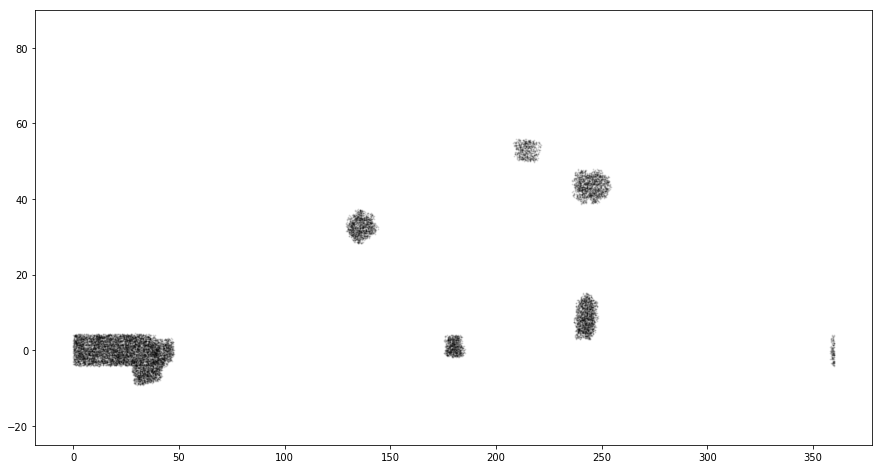

In [41]:
# Sky plot -- all fibers
pl.figure(figsize=(15,8))
r = np.argsort(np.random.random(len(t)))
s = np.arange(0,len(t))[r[::100]]
pl.scatter(t['TARGET_RA'][s],
           t['TARGET_DEC'][s],c='k',s=1,alpha=0.1)
pl.ylim(-25,90)
#pl.axis('equal')

Fractions of target pool observed requires MTL.

In [44]:
ls /global/cscratch1/sd/forero/dr8b/

bright_fiber_output_dr8/  input_tiles_bright.fits  mtl_dr8b-targets.fits
dark_fiber_output_dr8/    input_tiles_dark.fits


In [45]:
input_path = '/global/cscratch1/sd/forero/dr8b/'
!ls -lh $input_path

total 679M
drwxr-sr-x+ 2 forero desi  44K Mar 21 12:47 bright_fiber_output_dr8
drwxr-sr-x+ 2 forero desi  68K Mar 21 12:47 dark_fiber_output_dr8
-rw-r--r--+ 1 forero desi 301K Mar 21 12:44 input_tiles_bright.fits
-rw-r--r--+ 1 forero desi 498K Mar 21 12:44 input_tiles_dark.fits
-rw-r--r--+ 1 forero desi 678M Mar 21 12:44 mtl_dr8b-targets.fits


In [46]:
targets_path = '/global/cscratch1/sd/forero/dr8b/mtl_dr8b-targets.fits'
!ls -lh $targets_path

-rw-r--r--+ 1 forero desi 678M Mar 21 12:44 /global/cscratch1/sd/forero/dr8b/mtl_dr8b-targets.fits


In [47]:
targets = fitsio.read(targets_path,columns=['TARGETID','DESI_TARGET','MWS_TARGET'])

In [48]:
avail_ids = np.sort(pot['TARGETID'])

In [63]:
colhead = '{:10s} {:15s} {:15s} {:15s} {:15s} {:9s}'.format('','N_MTL','N_AVAIL','DENS_AVAIL','N_OBS','N_OBS_FULL','FRAC_OBS')

def trac_table(s,head=False):
    import re
    subst = ' =||= ' if head else ' || '
    new_s = re.sub('(\s)+',subst,s)
    
    if head:
        new_s = '||= {} =||'.format(new_s)
    else:
        new_s = '|| {}'.format(new_s)
    return new_s

print(trac_table(colhead,True))

for _ in ['MWS_ANY','BGS_ANY']:
    bitmask = desi_mask.mask(_)
    
    in_mtl      = targets['DESI_TARGET'] == bitmask #(targets['DESI_TARGET'] & bitmask) != 0
    total_mtl = in_mtl.sum()
    
    is_avail    = np.isin(targets['TARGETID'][in_mtl], avail_ids, assume_unique=True)
    total_avail = is_avail.sum()
    dens_avail  = 3*total_avail/A_TILE/ntiles
    total_obs   = np.sum(t['DESI_TARGET'] == bitmask)
    line = "{:10s} {:<15,d} {:<15,d} {:<15.1f} {:<15,d} {:<15,d} {:<6.3f}".format(_,
                                                           total_mtl,
                                                           total_avail,
                                                           dens_avail,
                                                           total_obs,
                                                           int(total_obs/trial_area_fraction),
                                                           float(total_obs)/total_avail)
    print(trac_table(line))

||=  =||= N_MTL =||= N_AVAIL =||= DENS_AVAIL =||= N_OBS =||= N_OBS_FULL =||
|| MWS_ANY || 232,480 || 232,264 || 281.0 || 114,883 || 2,323,874 || 0.495 || 
|| BGS_ANY || 350,528 || 350,195 || 423.7 || 289,857 || 5,863,281 || 0.828 || 


In [67]:
# Completeness for MWS targets only, removing overlaps
print('|| {:10s} || {:15s} || {:15s} || {:15s} || {:15s} || {:15s} || {:9s} ||'.format('',
                                                                          'N_MTL',
                                                                          'N_AVAIL',
                                                                          'DENS_AVAIL',
                                                                          'N_OBS',
                                                                          'N_OBS_FULL',
                                                                          'FRAC_OBS'))

pure_mws       = t['DESI_TARGET'] == (desi_mask.mask('MWS_ANY'))
pure_mws_mtl   = targets['DESI_TARGET'] == (desi_mask.mask('MWS_ANY'))

for name in ['WD','NEARBY','MAIN_BLUE','MAIN_RED','BROAD']:
    pure      = pure_mws & ((t['MWS_TARGET'] & mws_mask['MWS_{}'.format(name)])  != 0)
    in_mtl    = pure_mws_mtl & ((targets['MWS_TARGET'] & mws_mask['MWS_{}'.format(name)])  != 0)
    total_mtl = in_mtl.sum()
    
    is_avail    = np.isin(targets['TARGETID'][in_mtl], avail_ids, assume_unique=True)
    total_avail = is_avail.sum()
    dens_avail  = 3*total_avail/A_TILE/ntiles
    total_obs   = np.sum(pure)
    print("|| {:10s} || {:<15,d} || {:<15,d} || {:<15.1f} || {:<15,d} || {:<15,d} || {:<6.3f} ||".format(name,
                                                           total_mtl,
                                                           total_avail,
                                                           dens_avail,
                                                           total_obs,
                                                           int(total_obs/trial_area_fraction),
                                                           float(total_obs)/total_avail))
    sys.stdout.flush()

||            || N_MTL           || N_AVAIL         || DENS_AVAIL      || N_OBS           || N_OBS_FULL      || FRAC_OBS  ||
|| WD         || 0               || 0               || 0.0             || 0               || 0               || nan    ||
|| NEARBY     || 1,723           || 1,722           || 2.1             || 1,291           || 26,114          || 0.750  ||


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in true_divide


|| MAIN_BLUE  || 78,276          || 78,199          || 94.6            || 43,171          || 873,271         || 0.552  ||
|| MAIN_RED   || 32,099          || 32,064          || 38.8            || 18,533          || 374,889         || 0.578  ||
|| BROAD      || 120,664         || 120,561         || 145.9           || 52,091          || 1,053,706       || 0.432  ||


In [68]:
# Completeness for MWS targets including overlaps
print('|| {:10s} || {:15s} || {:15s} || {:15s} || {:15s} || {:15s} || {:9s} ||'.format('',
                                                                          'N_MTL',
                                                                          'N_AVAIL',
                                                                          'DENS_AVAIL',
                                                                          'N_OBS',
                                                                          'N_OBS_FULL',
                                                                          'FRAC_OBS'))

mws       = (t['DESI_TARGET'] & (desi_mask.mask('MWS_ANY'))) != 0
mws_mtl   = (targets['DESI_TARGET'] & (desi_mask.mask('MWS_ANY'))) != 0

for name in ['WD','NEARBY','MAIN_BLUE','MAIN_RED','BROAD']:
    in_fibers = mws & ((t['MWS_TARGET'] & mws_mask['MWS_{}'.format(name)]) != 0)
    in_mtl    = mws_mtl & ((targets['MWS_TARGET'] & mws_mask['MWS_{}'.format(name)]) != 0)
    total_mtl = in_mtl.sum()
    
    is_avail    = np.isin(targets['TARGETID'][in_mtl], avail_ids, assume_unique=True)
    total_avail = is_avail.sum()
    dens_avail  = 3*total_avail/A_TILE/ntiles
    total_obs   = np.sum(in_fibers)
    print("|| {:10s} || {:<15,d} || {:<15,d} || {:<15.1f} || {:<15,d} || {:<15,d} || {:<6.3f} ||".format(name,
                                                           total_mtl,
                                                           total_avail,
                                                           dens_avail,
                                                           total_obs,
                                                           int(total_obs/trial_area_fraction),
                                                           float(total_obs)/total_avail))
    sys.stdout.flush()

||            || N_MTL           || N_AVAIL         || DENS_AVAIL      || N_OBS           || N_OBS_FULL      || FRAC_OBS  ||
|| WD         || 1,348           || 1,347           || 1.6             || 2,115           || 42,782          || 1.570  ||
|| NEARBY     || 1,816           || 1,815           || 2.2             || 1,422           || 28,764          || 0.783  ||
|| MAIN_BLUE  || 97,752          || 97,655          || 118.1           || 60,836          || 1,230,602       || 0.623  ||
|| MAIN_RED   || 32,216          || 32,180          || 38.9            || 18,735          || 378,975         || 0.582  ||
|| BROAD      || 120,742         || 120,639         || 146.0           || 52,210          || 1,056,113       || 0.433  ||


In [61]:
with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(t['FLUX_G'])+22.5
    r = -2.5*np.log10(t['FLUX_R'])+22.5
warning_summary(W)
    
is_mws    = t['MWS_TARGET'] != 0
is_bgs    = t['BGS_TARGET'] != 0 
is_nearby = t['MWS_TARGET'] & mws_mask['MWS_NEARBY'] != 0 
is_wd     = t['MWS_TARGET'] & mws_mask['MWS_WD'] != 0 
is_main   = is_mws & ~(is_wd|is_nearby)


WARNING         COUNT
RuntimeWarning  4


WARNING         COUNT
RuntimeWarning  1
WARNING         COUNT
RuntimeWarning  1
WARNING         COUNT
RuntimeWarning  2


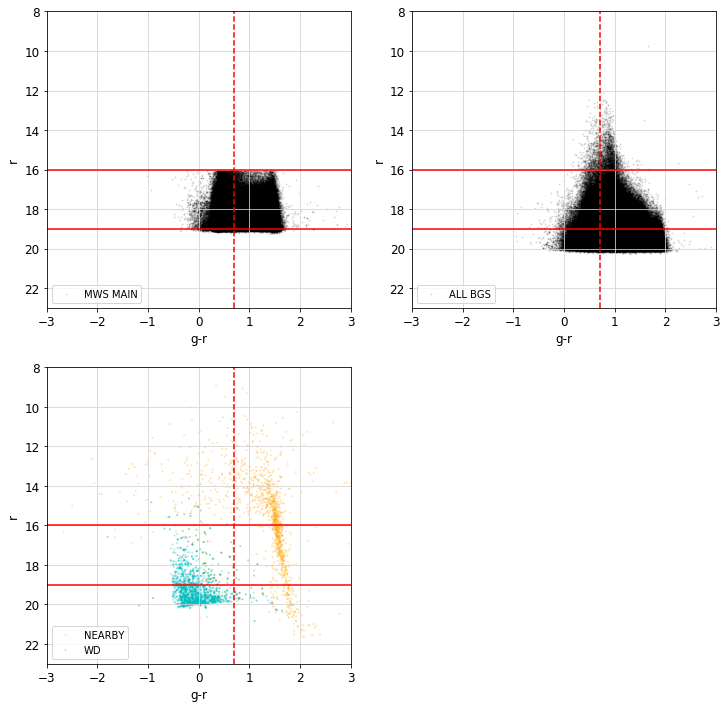

In [62]:
# Colour-magnitude of observed targets
pl.figure(figsize=(12,12))

# All MWS Main
ax = pl.subplot(221)
with warnings.catch_warnings(record=True) as W:
    pl.scatter((g-r)[is_main], r[is_main]
               ,s=1,alpha=0.1,c='k',label='MWS MAIN')
#    pl.scatter((g-r)[is_bgs & is_main],r[is_bgs & is_main], 
#               s=70, alpha=0.3,facecolor='None',edgecolor='g',marker='o',zorder=-10,label='BGS Overlap')
warning_summary(W)

pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')

ax = pl.subplot(222)
with warnings.catch_warnings(record=True) as W:
    pl.scatter((g-r)[is_bgs],r[is_bgs],s=1,
               alpha=0.1,c='k',label='ALL BGS')
warning_summary(W)

pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')

ax = pl.subplot(223)
with warnings.catch_warnings(record=True) as W:
    pl.scatter((g-r)[is_nearby],r[is_nearby], 
               s=1, facecolor='None',edgecolor='orange',label='NEARBY',alpha=0.3)
    pl.scatter((g-r)[is_wd],r[is_wd], 
               s=1, facecolor='None',edgecolor='c',label='WD',alpha=0.3)
#    pl.scatter((g-r)[is_bgs & (is_wd|is_nearby)],r[is_bgs & (is_wd|is_nearby)], 
#           s=70, alpha=0.3,facecolor='None',edgecolor='g',marker='o',zorder=-10,label='BGS Overlap')
warning_summary(W)
 
pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)
pl.xlim(-3,3)
pl.legend(loc='lower left')